# YOUR PROJECT TITLE

Imports and set magics:

In [2]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject
from modelproject import SolowModelClass 
model = SolowModelClass()

initializing the model:
calling .setup()


# Model description

In the following project, we use the exam in Macroeconomics I from 09 January 2020 as a starting point.

We focus on a version of the Solow model, where climate change causes damage to output. 

$Y_t = [1-D]K_t^\alpha (A_t L_t)^{1-\alpha}, 0 <\alpha<1$

$D=1-\frac{1}{1+\sigma{(\Delta T)}^2}, \sigma > 0$

$K_{t+1}=s Y_t+(1-\delta) K_t, 0<s<1,0<\delta<1,K_0>0$

$A_{t+1}=(1+g)A_t, A_0>0$

$L_{t+1}=(1+n)A_t, L_0>0$

The first equation is a Cobb-Douglas production function describing total output $(Y_t)$ as a function of physical capital $(K_t)$, population size $(L_t)$ and technology level $(A_t)$. We assume that climate change reduces output by share D; i.e. a part of output $(DY_t)$ is destroyed and only the share $1-D$ of output can be used for consumption and investment. The damage from climate change is given by the second equation, where $T$ measures change in temperature. Capital accumulation is described by the third equation, where $s$ is the saving rate and $\delta$ is the attrition rate. The last two equations indicate how the level of technology $(A_t)$ and the population $(L_t)$ evolve over time.

We define $\tilde y_t=\frac{Y_t}{A_tL_t}$ and $\tilde k_t = \frac{K_t}{A_tL_t}$.

Udledning af transistionsligning 
Fase diagram

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

We find the transition equation for capital per worker:

$$
\begin{aligned}
\frac{K_{t+1}}{A_{t+1} L_{t+1}} & =\frac{s Y_t+(1-\delta) K_t}{(1+g)(1+n) A_t L_t} \Leftrightarrow \\
\tilde{k}_{t+1} & =\frac{1}{(1+n)(1+g)}\left(s \tilde{y}_t+(1-\delta) \tilde{k}_t\right) \Leftrightarrow \\
\tilde{k}_{t+1} & =\frac{1}{(1+n)(1+g)}\left(s[1-D] \tilde{k}_t^\alpha+(1-\delta) \tilde{k}_t\right)
\end{aligned}
$$

This can be shown in a phase diagram, where we see that the model converges to it's steady state value, irrespective of starting value.

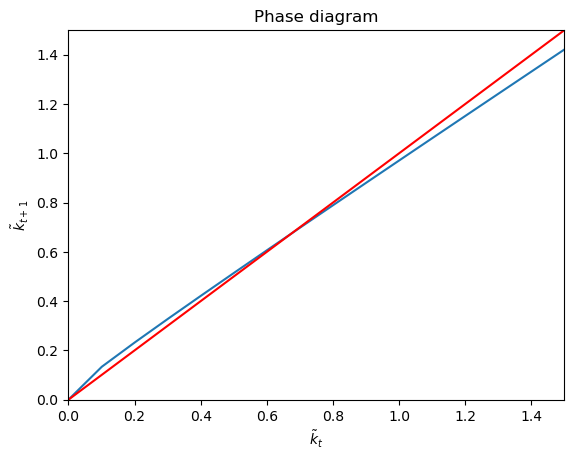

In [8]:
# calling model parameters 
val = model.val

# define the transition equation with the production function integrated
kt1 = lambda k:(val.s*(1-val.d)*k**val.alpha + (1-val.delta)*k)/((1+val.g)*(1+val.n))

# generate a range of values for kt1
kt1_range = np.linspace(0, 10, 100)

# create a plot of the transition equation function
plt.plot(kt1_range, kt1(kt1_range))

# plot a line with slope 1 to represent the 45-degree line
plt.plot([0, 1.5], [0, 1.5], color='r')

# set the x and y limits
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

# label the axes
plt.xlabel(r'$\tilde k_t$')
plt.ylabel(r'$\tilde k_{t+1}$')

# set title
plt.title('Phase diagram')

# show the plot
plt.show()

In steady state $\tilde{k}_{t+1}=\tilde{k}_{t}=\tilde{k}^*$. We then find the steady state for capital to be: 

In [4]:
model.solve_analytical_ss()

((-delta - g*n - g - n)/(s*(D - 1)))**(1/(alpha - 1))

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

In [4]:
# create a list of values for d
d_vec = np.linspace(0,1,5,endpoint=False)

# create an empty list to store the results
k_ss_list = []
y_ss_list = []
relative_y_ss_list = []

for d in d_vec:
    model.val.d = d
    k_ss, y_ss = model.solve_num_ss()
    k_ss_list.append(k_ss)
    y_ss_list.append(y_ss)
    rel_y_ss = y_ss/y_ss_list[0]*100
    relative_y_ss_list.append(rel_y_ss)

    print(f'd = {d:.1f}: \n Steady state for k is {k_ss:.1f} \n steady state for y is {y_ss:.1f} \n Steady state output per worker relative to a world without climate change is {rel_y_ss:.1f}% \n')

d = 0.0: 
 Steady state for k is 1.9 
 steady state for y is 1.2 
 Steady state output per worker relative to a world without climate change is 100.0% 

d = 0.2: 
 Steady state for k is 1.4 
 steady state for y is 0.9 
 Steady state output per worker relative to a world without climate change is 71.7% 

d = 0.4: 
 Steady state for k is 0.9 
 steady state for y is 0.6 
 Steady state output per worker relative to a world without climate change is 46.7% 

d = 0.6: 
 Steady state for k is 0.5 
 steady state for y is 0.3 
 Steady state output per worker relative to a world without climate change is 25.5% 

d = 0.8: 
 Steady state for k is 0.2 
 steady state for y is 0.1 
 Steady state output per worker relative to a world without climate change is 9.1% 



In the following we wish to simulate the development in...

In [11]:
sim = model.sim
model.simulate()

(0.5, 8.0)

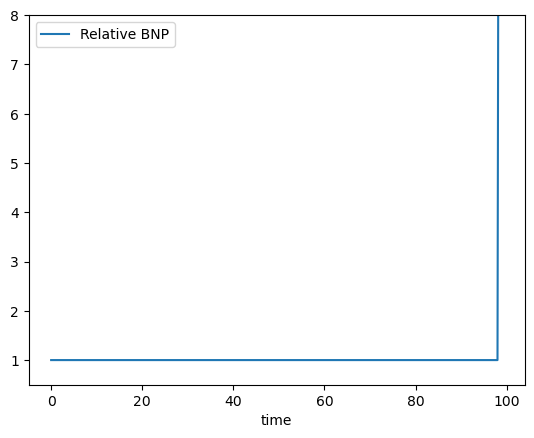

In [12]:
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.fracY[:simT_fig],label='Relative BNP')
ax.set_xlabel('time')
ax.legend(frameon=True);
plt.ylim([0.5,8])

# Conclusion

Add concise conclusion. 